# Student Performance Improvement - An Analysis

# Problem Overview
The objective is to enhance student performance on standardized exams by identifying and addressing key factors influencing academic outcomes. This strategy aims to leverage data insights to inform evidence-based interventions.

# Objectives
1. Primary Objective:
  - Identify key factors affecting students' exam scores.

2. Secondary Objectives:
  - Develop predictive models for student performance.

  - Segment students into actionable clusters based on performance-related attributes.

  - Provide targeted recommendations for intervention strategies.
 
# Data Summary
The dataset contains 6,607 records with variables categorized as follows:

1. Study & Academic Factors: `Hours_Studied`, `Attendance`, `Previous_Scores`, `Tutoring_Sessions`.

2. Parental & Socioeconomic Factors: `Parental_Involvement`, `Family_Income`, `Parental_Education_Level`.

3. Personal & Lifestyle Factors: `Sleep_Hours`, `Motivation_Level`, `Physical_Activity`.

4. School Environment Factors: `Teacher_Quality`, `Peer_Influence`, `School_Type`, `Distance_from_Home`.

5. Outcome Variable: `Exam_Score`.


# Phase 1: Data Preparation 

I'm gonna start by loading the dataset into a pandas DataFrame and reviewing its initial structure. 

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans

# Data Preparation
data = pd.read_csv('student_performance_factors.csv')
print("\nDataset Info:")
data.info()

# Checking the first few rows.
print("\nFirst few rows of the dataset:")
data.head()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


I found missing values in some columns like `Teacher_Quality`, `Parental_Education_Level`, and `Distance_from_Home`. To address these, I'm going to fill the missing values with the mode (i.e., the most frequently occurring value) for each respective column. I'm also going to look for outliers in `Hours_Studied` and `Sleep_Hours` using the IQR method. Outliers can skew the results of our analysis, so I will removed any data points that were significantly different from the rest. 

In [2]:
# Handle Missing Values
for col in ['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home']:
    data[col] = data[col].fillna(data[col].mode()[0])

# Outlier Removal for Numerical Features
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

data_cleaned = remove_outliers(data, 'Hours_Studied')
data_cleaned = remove_outliers(data_cleaned, 'Sleep_Hours')
data_cleaned.to_csv('cleaned_student_performance_factors.csv', index=False)
print("\nShape of dataset after cleaning:", data_cleaned.shape)


Shape of dataset after cleaning: (6564, 20)


# Phase 2: Exploratory Data Analysis 

I will first generate descriptive statistics for key numerical features like `Hours_Studied`, `Sleep_Hours`, `Attendance`, and `Exam_Score`. This will help me understand the central tendencies (mean, median) and the spread of the data.

In [3]:
# Descriptive Statistics for Numerical Columns
numerical_cols = ['Hours_Studied', 'Sleep_Hours', 'Previous_Scores', 'Attendance', 'Physical_Activity', 'Exam_Score']
descriptive_stats = data_cleaned[numerical_cols].describe()
print("\nDescriptive Statistics:")
descriptive_stats


Descriptive Statistics:


,Hours_Studied,Sleep_Hours,Previous_Scores,Attendance,Physical_Activity,Exam_Score
count,6564.000000,6564.000000,6564.000000,6564.000000,6564.000000,6564.000000
mean,19.969226,7.029403,75.081810,79.955972,2.968160,67.226996
std,5.828309,1.467372,14.402906,11.540905,1.030714,3.852922
min,4.000000,4.000000,50.000000,60.000000,0.000000,56.000000
25%,16.000000,6.000000,63.000000,70.000000,2.000000,65.000000
50%,20.000000,7.000000,75.000000,80.000000,3.000000,67.000000
75%,24.000000,8.000000,88.000000,90.000000,4.000000,69.000000
max,36.000000,10.000000,100.000000,100.000000,6.000000,101.000000


I'm going to calculate the correlation matrix to check the linear relationships between these numerical features. I'm also going to create:
 - A heatmap of the correlation matrix, which clearly shows the relationships between the features.

 - Histograms to see the distribution of the numerical features.
 
 - Scatter plots to explore how `Exam_Score` relates to `Hours_Studied`, `Attendance`, and `Previous_Scores`.

In [4]:
# Correlation Analysis
correlation_matrix = data_cleaned[numerical_cols].corr()
print("\nCorrelation Matrix:")
correlation_matrix


Correlation Matrix:


,Hours_Studied,Sleep_Hours,Previous_Scores,Attendance,Physical_Activity,Exam_Score
Hours_Studied,1.000000,0.010724,0.019668,-0.011009,0.002855,0.437572
Sleep_Hours,0.010724,1.000000,-0.020315,-0.017882,-0.000691,-0.016435
Previous_Scores,0.019668,-0.020315,1.000000,-0.019708,-0.008723,0.174719
Attendance,-0.011009,-0.017882,-0.019708,1.000000,-0.022828,0.584579
Physical_Activity,0.002855,-0.000691,-0.008723,-0.022828,1.000000,0.028716
Exam_Score,0.437572,-0.016435,0.174719,0.584579,0.028716,1.000000


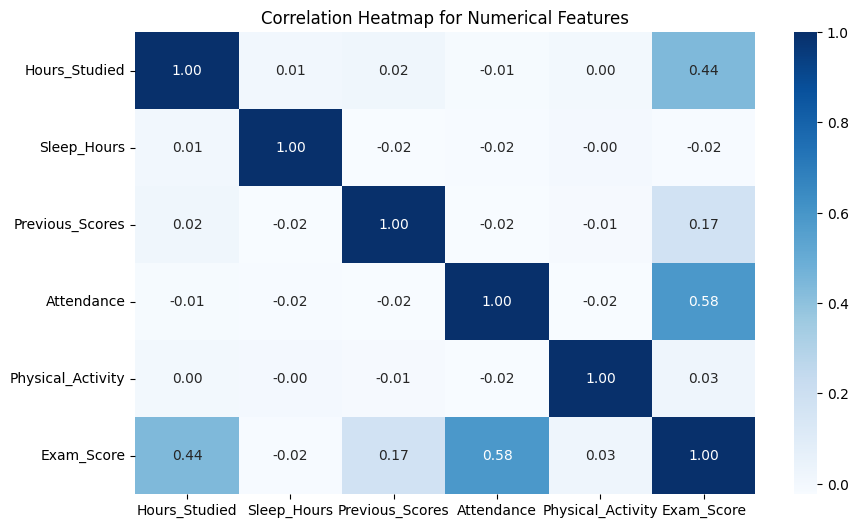

In [5]:
# Visualizations
# Plotting a correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title("Correlation Heatmap for Numerical Features")
plt.show()

I found that `Exam_Score` has a strong positive correlation with `Attendance` and a moderate positive correlation with `Hours_Studied`. This suggests that students who attend classes regularly and study more tend to perform better. 

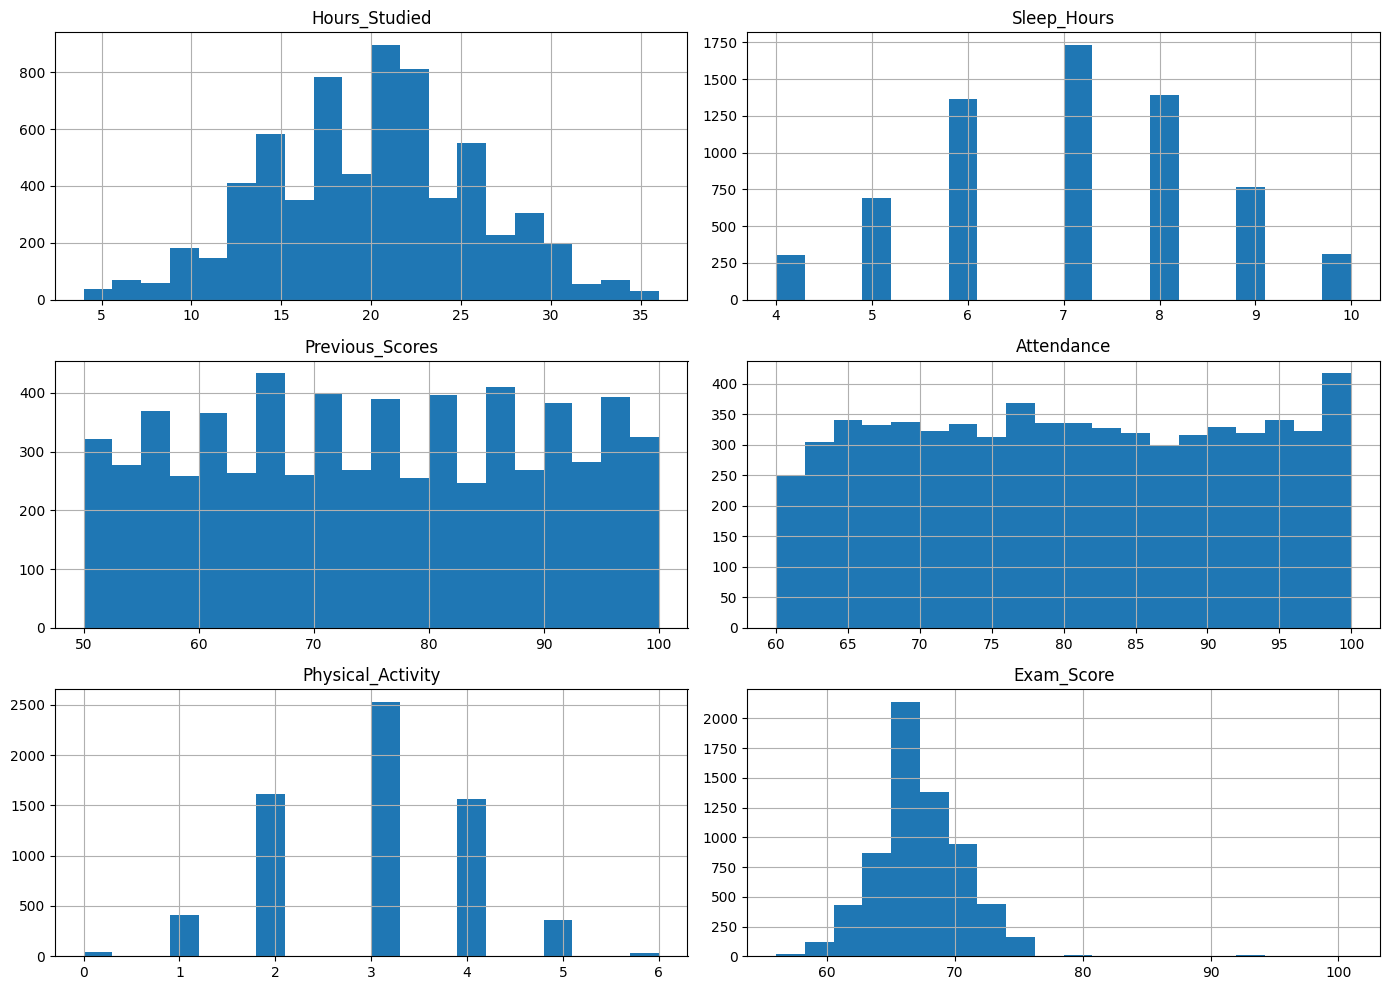

In [6]:
# Histograms for Numerical Features
data_cleaned[numerical_cols].hist(bins=20, figsize=(14,10))
plt.tight_layout()
plt.show()

The histograms show that most students study between 16 to 24 hours weekly and get 7 to 8 hours of sleep, which aligns with recommended health guidelines. `Previous_Scores` are concentrated between 63 and 88, suggesting average to above-average academic performance. `Attendance` is generally high, indicating a disciplined student population, while `Exam Scores` are clustered between 65 and 70, with fewer students at the extremes.

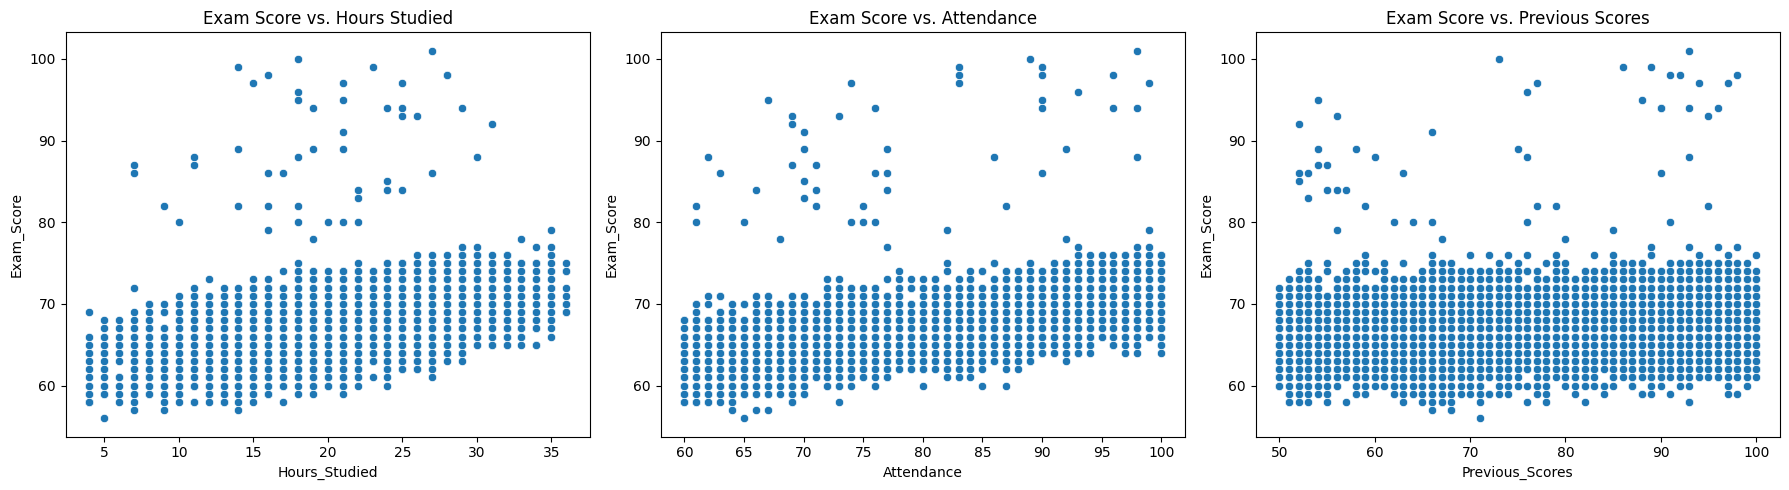

In [7]:
# Scatter plots for key relationships
# Examining the relationships between Exam_Score and Hours_Studied, Attendance, and Previous_Scores
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.scatterplot(ax=axes[0], data=data_cleaned, x='Hours_Studied', y='Exam_Score')
axes[0].set_title("Exam Score vs. Hours Studied")
sns.scatterplot(ax=axes[1], data=data_cleaned, x='Attendance', y='Exam_Score')
axes[1].set_title("Exam Score vs. Attendance")
sns.scatterplot(ax=axes[2], data=data_cleaned, x='Previous_Scores', y='Exam_Score')
axes[2].set_title("Exam Score vs. Previous Scores")
plt.tight_layout()
plt.show()

The scatter plots reveal a clear positive relationship between `Exam_Scores` and both `Hours_Studied` and `Attendance`. Students who study more and attend classes regularly tend to perform better, although diminishing returns are visible beyond 30 study hours. A moderate positive trend between `Previous_Scores` and `Exam_Scores` suggests that consistent past performance is a good predictor of future success.

# Phase 3: Predictive Modelling

I'm going to train and test different machine learning models to predict students' exam scores based various factors. First, I will split the data into two parts — 80% for training the models and 20% for testing how well they perform.  

I scaled the numerical features like `Hours_Studied` and `Previous_Scores` and used one-hot encoding for categorical features like `Parental_Involvement` and `School_Type`. This made sure the data was in the right format for the models.  

I'm going to test four models: Linear Regression, Decision Tree, Random Forest, and Gradient Boosting. For each model, I will calculate two key metrics: 
 
- **RMSE (Root Mean Squared Error):** This shows how far the predicted scores are from the actual ones.  

- **R² Score:** This tells me how much of the variation in exam scores the model can explain.  

In [8]:
# Load the dataset
file_path = "cleaned_student_performance_factors.csv"  
df = pd.read_csv(file_path)

# Identify numerical and categorical columns
numerical_cols = ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 
                  'Tutoring_Sessions', 'Physical_Activity']
categorical_cols = ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 
                    'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 
                    'School_Type', 'Peer_Influence', 'Learning_Disabilities', 
                    'Parental_Education_Level', 'Distance_from_Home', 'Gender']

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Split data into features and target
X = df.drop(columns=['Exam_Score'])
y = df['Exam_Score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply transformations
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Function to train and evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5  # Compute RMSE manually
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} - RMSE: {rmse:.2f}, R²: {r2:.2f}")
    return rmse, r2

# Train and evaluate models
results = {}

# Linear Regression
results["Linear Regression"] = evaluate_model(LinearRegression(), X_train, X_test, y_train, y_test, "Linear Regression")

# Decision Tree
results["Decision Tree"] = evaluate_model(DecisionTreeRegressor(random_state=42), X_train, X_test, y_train, y_test, "Decision Tree")

# Random Forest
results["Random Forest"] = evaluate_model(RandomForestRegressor(n_estimators=100, random_state=42), X_train, X_test, y_train, y_test, "Random Forest")

# Gradient Boosting
results["Gradient Boosting"] = evaluate_model(GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42), X_train, X_test, y_train, y_test, "Gradient Boosting")

Linear Regression - RMSE: 2.20, R²: 0.68
Decision Tree - RMSE: 3.19, R²: 0.33
Random Forest - RMSE: 2.51, R²: 0.59
Gradient Boosting - RMSE: 2.31, R²: 0.65


### Model Performance Summary
| Model               | RMSE  | R² Score |
|---------------------|------|---------|
| **Linear Regression**  | **2.20**  | **0.68**  |
| Decision Tree      | 3.19  | 0.33   |
| Random Forest      | 2.51  | 0.59   |
| Gradient Boosting  | 2.31  | 0.65   |

### Insights 
1. **Linear Regression performed best** with the **lowest RMSE (2.20) and highest R² (0.68)**.
   - This suggests a **linear relationship** between the features and **Exam Score**.

   - However, it may not capture complex interactions.
   
2. **Decision Tree performed the worst** (High RMSE, Low R²).
   - It likely **overfitted** to the training data.

   - Tuning hyperparameters like `max_depth` could improve it.

3. **Random Forest improved performance** over the Decision Tree but still lagged behind Linear Regression.
   - More trees `n_estimators` and depth tuning could help.

4. **Gradient Boosting performed second best** (RMSE: 2.31, R²: 0.65).
   - With hyperparameter tuning, it could **potentially beat Linear Regression**.

To further improve performance, I will perform hyperparameter tuning using `GridSearchCV`. This technique tests different parameter combinations to find the best settings for each model:

1. Decision Tree: Tuned parameters like max depth, minimum samples split, and minimum samples per leaf.

2. Random Forest: Tuned parameters such as the number of trees, max depth, and minimum samples per leaf.

3. Gradient Boosting: Tuned parameters including the number of trees, learning rate, and max depth.

After tuning, I will re-evaluate the models to compare their performance using RMSE and R² scores. 

In [9]:
from sklearn.model_selection import GridSearchCV

# Define parameter grids
param_grid_dt = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Function to perform GridSearchCV
def tune_model(model, param_grid, X_train, y_train, model_name):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    return grid_search.best_estimator_

# Tune Decision Tree
best_dt = tune_model(DecisionTreeRegressor(random_state=42), param_grid_dt, X_train, y_train, "Decision Tree")

# Tune Random Forest
best_rf = tune_model(RandomForestRegressor(random_state=42), param_grid_rf, X_train, y_train, "Random Forest")

# Tune Gradient Boosting
best_gb = tune_model(GradientBoostingRegressor(random_state=42), param_grid_gb, X_train, y_train, "Gradient Boosting")

# Evaluate tuned models
results_tuned = {}

print("\nResults after tuning:")
results_tuned["Tuned Decision Tree"] = evaluate_model(best_dt, X_train, X_test, y_train, y_test, "Tuned Decision Tree")
results_tuned["Tuned Random Forest"] = evaluate_model(best_rf, X_train, X_test, y_train, y_test, "Tuned Random Forest")
results_tuned["Tuned Gradient Boosting"] = evaluate_model(best_gb, X_train, X_test, y_train, y_test, "Tuned Gradient Boosting")


Best parameters for Decision Tree: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 200}

Results after tuning:
Tuned Decision Tree - RMSE: 2.86, R²: 0.46
Tuned Random Forest - RMSE: 2.47, R²: 0.60
Tuned Gradient Boosting - RMSE: 2.27, R²: 0.66


### Tuned Model Performance Summary
| Model                   | RMSE  | R² Score |
|-------------------------|------|---------|
| **Tuned Decision Tree**  | 2.86  | 0.46   |
| **Tuned Random Forest**  | 2.47  | 0.60   |
| **Tuned Gradient Boosting**  | **2.27**  | **0.66**  |

### Insights
1. **Gradient Boosting is now the best model** 
   - **Lowest RMSE (2.27)** and **highest R² (0.66)**  

   - Tuning improved it slightly over the default (before tuning: RMSE = 2.31, R² = 0.65).

2. **Random Forest improved significantly**  
   - **RMSE dropped from 2.51 → 2.47**  

   - **R² increased from 0.59 → 0.60**  

   - The higher number of trees (200) and depth (20) helped.

3. **Decision Tree still underperforms**  
   - RMSE **increased** from **3.19 → 2.86**, but it's still much worse than ensemble models.  
   
   - Decision Trees tend to overfit, even with tuning.  

Now, I'm gonna apply feature importance to understand which factors influence student performance the most. Using the trained Random Forest and Gradient Boosting models, I will extract and plot the top 10 most important features. 

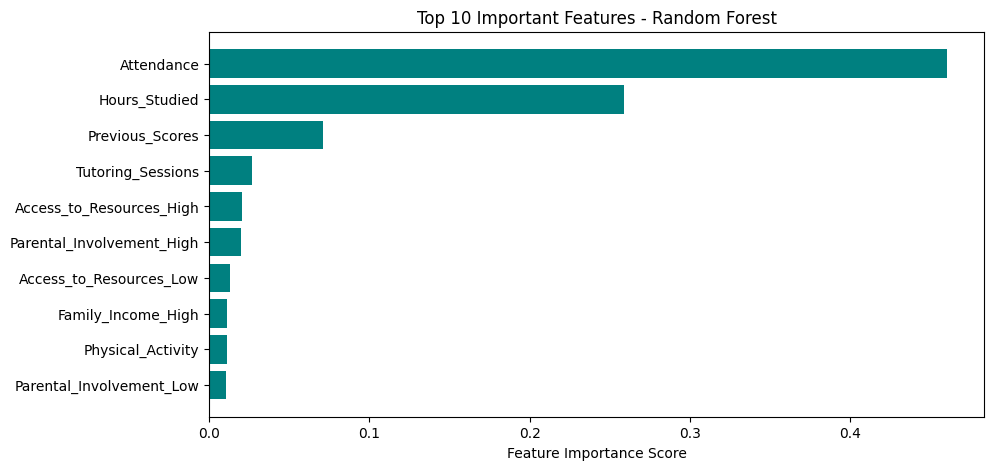

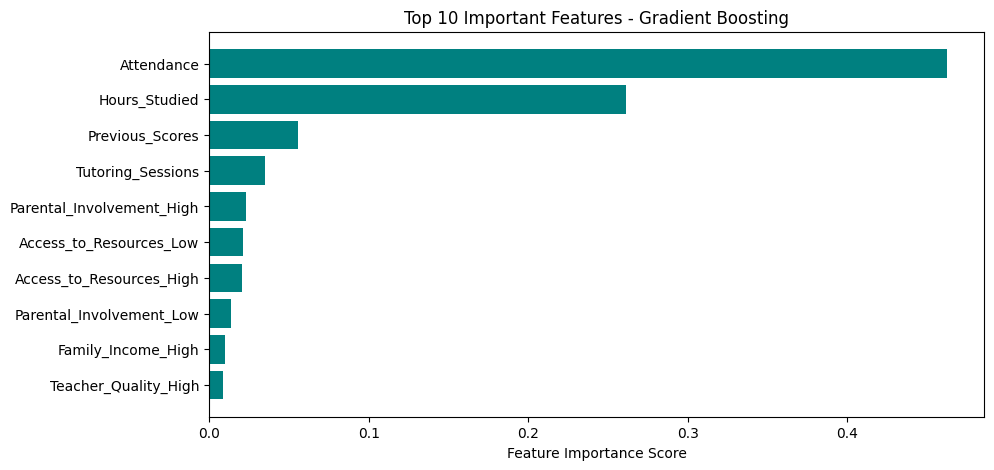

In [10]:
# Get feature names after encoding
feature_names = numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))

# Function to plot feature importance
def plot_feature_importance(model, model_name):
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)[-10:]  # Select top 10 features

    plt.figure(figsize=(10, 5))
    plt.barh(np.array(feature_names)[sorted_idx], importance[sorted_idx], color='teal')
    plt.xlabel("Feature Importance Score")
    plt.title(f"Top 10 Important Features - {model_name}")
    plt.show()

# Plot feature importance for Random Forest
plot_feature_importance(best_rf, "Random Forest")

# Plot feature importance for Gradient Boosting
plot_feature_importance(best_gb, "Gradient Boosting")

### Insights 

| **Rank** | **Gradient Boosting**         | **Random Forest**           |
|----------|--------------------------------|------------------------------|
| 1        | Attendance                    | Attendance                  |
| 2        | Hours_Studied                 | Hours_Studied               |
| 3        | Previous_Scores               | Previous_Scores             |
| 4        | Tutoring_Sessions             | Tutoring_Sessions           |
| 5        | Parental_Involvement_High     | Access_to_Resources_High    |
| 6        | Access_to_Resources_Low       | Parental_Involvement_High   |
| 7        | Access_to_Resources_High      | Access_to_Resources_Low     |
| 8        | Parental_Involvement_Low      | Family_Income_High          |
| 9        | Family_Income_High            | Physical_Activity           |
| 10       | Teacher_Quality_High          | Parental_Involvement_Low    |

### Observations:  
1. **Consensus:**  
   Both models agree that "Attendance" and "Hours Studied" are the most impactful features.  
   
2. **Divergence:**  
   - Gradient Boosting emphasizes "Parental Involvement" and "Teacher Quality."  
   - Random Forest highlights "Access to Resources" and "Physical Activity."  

### Feature Selection:  
Given the consensus on key factors and domain knowledge, I'm selecting these features for cluster analysis:  
1. Attendance  
2. Hours_Studied  
3. Previous_Scores  
4. Tutoring_Sessions  
5. Access_to_Resources (both High and Low)  
6. Parental_Involvement (both High and Low)  

# Phase 4: Cluster Analysis

The dataset contains categorical columns like `Access_to_Resources` and `Parental_Involvement`, which are in text form. Since clustering algorithms require numerical data, I will convert these using **Label Encoding**. If needed, I may switch to **One-Hot Encoding** for better performance.  

The dataset also includes numerical variables like `Attendance`, `Hours_Studied`, `Previous_Scores`, and `Tutoring_Sessions`. Since clustering relies on distance calculations, I will apply **Standardization** with `StandardScaler()` to ensure all features contribute equally.

In [17]:
# Preprocess the data (encode categorical variables, scale numeric features)
categorical_cols = ['Access_to_Resources', 'Parental_Involvement']
numerical_cols = ['Attendance', 'Hours_Studied', 'Previous_Scores', 'Tutoring_Sessions']

# Label Encoding for categorical features
label_encoder = LabelEncoder()
# Apply label encoding to each categorical column
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

# Standardize numerical features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

I will apply **K-Means clustering** to group similar data points using both numerical and encoded categorical features. Since K-Means requires a predefined number of clusters `k`, I will use the **Elbow Method** to determine the optimal value. By testing different `k` values (from 1 to 10) and calculating **inertia** (a measure of clustering quality), I will plot an Elbow graph to identify where the inertia curve sharply bends. Based on this, I will choose 3 clusters. This will ensure well-separated and meaningful groupings in the dataset.

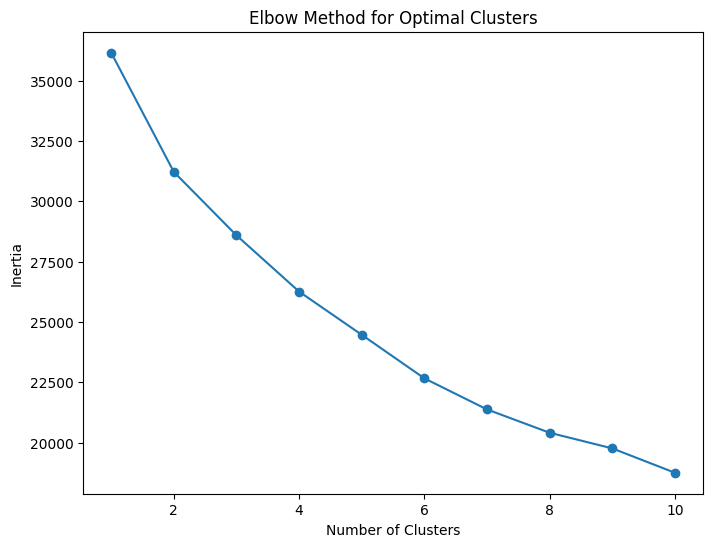

In [18]:
# Apply K-Means Clustering
X = df[numerical_cols + categorical_cols]  # Features to cluster on

# Determine the optimal number of clusters using the Elbow Method
inertia = []
for k in range(1, 11):  # Test k from 1 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

# From the Elbow plot, choose the number of clusters (e.g., 3 clusters)
optimal_k = 3

I will fit **K-Means** with the optimal number of clusters and assign each data point a **Cluster Label**. This will help group similar data points based on their features.  

To understand the characteristics of each cluster, I will perform a **Profile Analysis** by calculating the **mean values** of numerical and categorical features for each cluster. I will analyze performance across clusters by categorizing students based on their **Previous Scores**. Those in the **top 25%** will be labeled as **High Performing**, the **bottom 25%** as **At-Risk**, and the **middle 50%** as **Average**.  

After assigning performance labels, I will examine how performance is distributed within each cluster. By grouping data by **Cluster Label** and counting performance categories, I will gain insights into how different clusters relate to academic performance. If needed, I will adjust thresholds and re-run the analysis for better accuracy.

In [19]:
# Fit K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster_Label'] = kmeans.fit_predict(X)

# Profile Analysis
# Analyze the characteristics of each cluster (mean values of features for each cluster)
cluster_profile = df.groupby('Cluster_Label')[numerical_cols + categorical_cols].mean()

In [20]:
# Analyze Performance Across Clusters
def categorize_performance(row):
    if row['Previous_Scores'] > df['Previous_Scores'].quantile(0.75):  # Top 25% as high performance
        return 'High Performing'
    elif row['Previous_Scores'] < df['Previous_Scores'].quantile(0.25):  # Bottom 25% as at-risk
        return 'At-Risk'
    else:  # The middle 50% as average performance
        return 'Average'

df['Performance'] = df.apply(categorize_performance, axis=1)

# Re-run the analysis after adjusting thresholds
cluster_performance_profile = df.groupby('Cluster_Label')['Performance'].value_counts()

Now it's time to visualize the results.

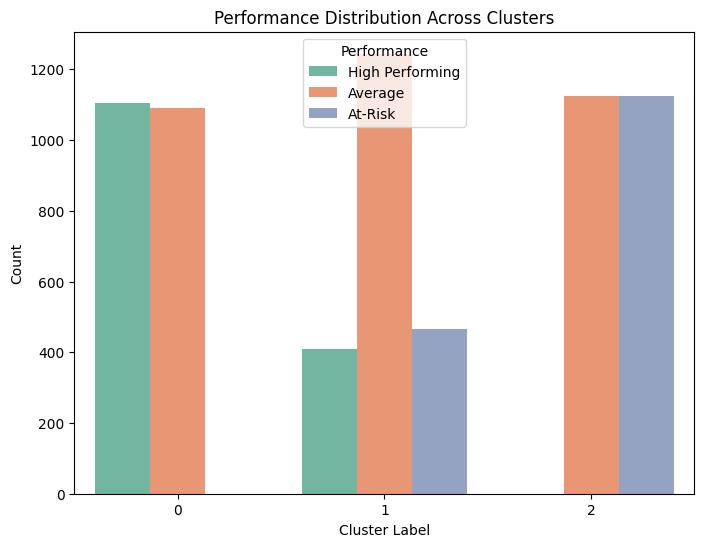

In [21]:
# Visualize Cluster Performance
# Bar plot showing the distribution of performance across clusters
plt.figure(figsize=(8, 6))
sns.countplot(x='Cluster_Label', hue='Performance', data=df, palette='Set2')
plt.title("Performance Distribution Across Clusters")
plt.xlabel("Cluster Label")
plt.ylabel("Count")
plt.show()

In [22]:
# Display cluster profiles
print("Cluster Profile (Mean Values of Features for Each Cluster):")
display(cluster_profile)

print("\nPerformance Distribution Across Clusters:")
display(cluster_performance_profile)

Cluster Profile (Mean Values of Features for Each Cluster):


,Attendance,Hours_Studied,Previous_Scores,Tutoring_Sessions,Access_to_Resources,Parental_Involvement
Cluster_Label,,,,,,
0,-0.088330,0.045871,0.924644,-0.056215,1.219234,1.739745
1,0.012195,-0.035108,-0.019568,0.020890,1.172642,0.107547
2,0.074641,-0.011650,-0.883194,0.035133,1.220444,1.764000



Performance Distribution Across Clusters:


Cluster_Label  Performance    
0              High Performing    1104
               Average            1090
1              Average            1244
               At-Risk             467
               High Performing     409
2              At-Risk            1125
               Average            1125
Name: count, dtype: int64

# Insights and Recommendations

### Key Factors Influencing Exam Scores  
The clustering analysis revealed the following student performance patterns:  
- **Cluster 0:**  
   - Predominantly high-performing (1,104 students) and average students (1,090 students).  

- **Cluster 1:**  
   - Mixed group with average (1,244 students), at-risk (467 students), and some high-performing (409 students) students.  

- **Cluster 2:**  
   - Primarily at-risk (1,125 students) and average (1,125 students) students.  


### Intervention Strategies 

- **For High-Risk Students (Clusters 1 & 2):**  
   - Provide targeted tutoring and additional support in weak areas.  

   - Offer motivational counseling to boost confidence and engagement.  

   - Emphasize healthy lifestyle habits, including proper sleep and physical activity.  

- **For Average Students (All Clusters):**  
   - Encourage better study planning and time management techniques.  

   - Strengthen parental involvement by keeping parents informed about student progress and providing learning resources.  

- **For High-Performing Students (Clusters 0 & 1):**  
   - Offer advanced learning opportunities, including enrichment programs or challenging extracurricular activities.  

   - Provide leadership roles, such as peer mentoring and organizing study sessions.  

### Policy Recommendations
- **Improve Teacher Quality:** Provide professional development programs to help teachers better address diverse student needs.  

- **Foster Positive Peer Environments:** Implement peer mentoring programs and activities that promote positive collaboration.  

- **Parental Workshops:** Conduct workshops to educate parents on supporting student learning at home and fostering effective study habits.  